Usando dispositivo: cpu
Cargando datos de test...

Iniciando evaluación comparativa...
Evaluando: lstm_base_best_model.pth ...
Evaluando: lstm_attn_best_model.pth ...
Evaluando: gru_base_best_model.pth ...
Evaluando: gru_attn_best_model.pth ...
Evaluando: lstm_bi_best_model.pth ...
Evaluando: lstm_bi_attn_best_model.pth ...

=== TABLA DE RESULTADOS ===
          Model  Accuracy  Macro F1
5  lstm_bi_attn  0.783520  0.696402
1     lstm_attn  0.768156  0.683998
4       lstm_bi  0.771648  0.682365
3      gru_attn  0.762570  0.674514
0     lstm_base  0.750698  0.664649
2      gru_base  0.747207  0.660592


C:\Users\andsa\AppData\Local\Temp\ipykernel_21080\830616648.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Macro F1', data=results_df, palette='viridis')


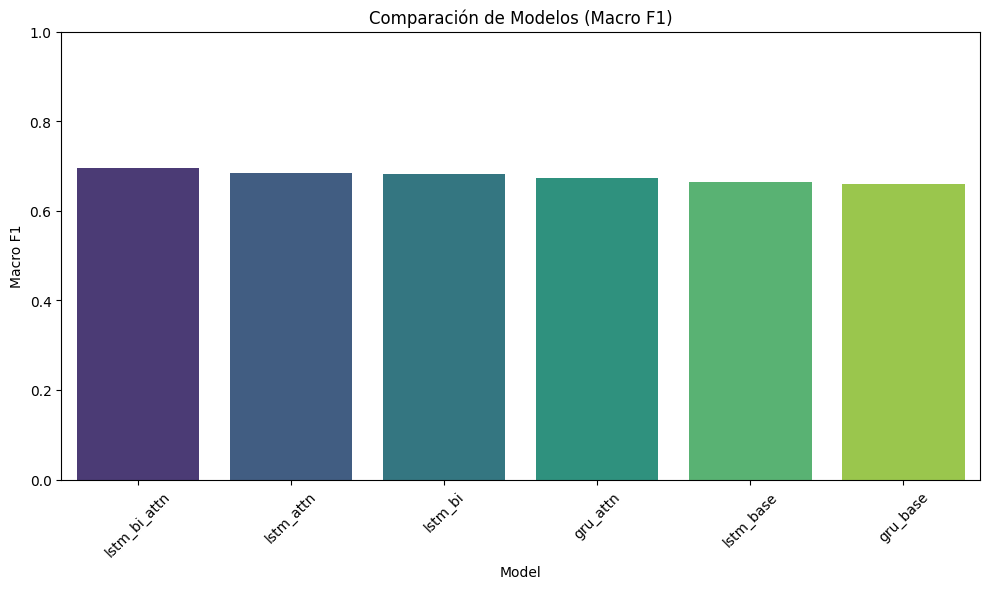


🏆 Mejor modelo seleccionado para inferencia: lstm_bi_attn_best_model.pth

--- PRUEBA INTERACTIVA ---
Texto: Bitcoin is crashing hard! Sell everything!
Predicción: Neutral (94.39%)

Texto: Great news for the market, bullish trend confirmed.
Predicción: Neutral (94.45%)

Texto: The market is closed today.
Predicción: Alcista (58.98%)



In [2]:
# =============================================================================
# NOTEBOOK 3: EVALUACIÓN COMPARATIVA E INFERENCIA
# =============================================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# -----------------------------------------------------------------------------
# CONFIGURACIÓN
# -----------------------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "data_processed"
MODELS_DIR = "models"

print(f"Usando dispositivo: {DEVICE}")

# -----------------------------------------------------------------------------
# 1. CLASES DEL MODELO (Deben coincidir con el entrenamiento)
# -----------------------------------------------------------------------------
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output, mask):
        scores = self.attn(rnn_output).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(rnn_output * attn_weights.unsqueeze(-1), dim=1)
        return context, attn_weights

class RecurrentClassifier(nn.Module):
    def __init__(self, model_type, vocab_size, embed_dim, hidden_dim, out_dim, n_layers, dropout, pad_idx, bidirectional=False, use_attention=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.model_type = model_type
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        if model_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        else:
            self.rnn = nn.GRU(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=bidirectional)
        
        self.rnn_out_dim = hidden_dim * (2 if bidirectional else 1)
        
        if use_attention:
            self.attention = AttentionPooling(self.rnn_out_dim)
        else:
            self.attention = None
            
        self.fc = nn.Linear(self.rnn_out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, x, lengths=None):
        mask = (x != self.pad_idx).float()
        emb = self.embedding(x)
        
        if self.model_type == 'lstm':
            rnn_out, (h_n, c_n) = self.rnn(emb)
        else:
            rnn_out, h_n = self.rnn(emb)
            
        attn_weights = None
        if self.use_attention:
            context, attn_weights = self.attention(rnn_out, mask)
        else:
            if self.bidirectional:
                h_last = h_n.view(self.n_layers, 2, x.size(0), self.hidden_dim)[-1]
                context = torch.cat([h_last[0], h_last[1]], dim=1)
            else:
                context = h_n[-1]
                
        logits = self.fc(self.dropout(context))
        return logits, attn_weights

# -----------------------------------------------------------------------------
# 2. CARGA DE DATOS DE TEST
# -----------------------------------------------------------------------------
print("Cargando datos de test...")
vocab = pickle.load(open(f"{DATA_DIR}/vocab.pkl", "rb"))
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

PAD_IDX = vocab["<PAD>"]
UNK_IDX = vocab["<UNK>"]

def encode_text(text, vocab):
    tokens = str(text).lower().split()
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]
    return torch.tensor(ids, dtype=torch.long)

class FinancialTweetsDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["text"]
        label = int(self.df.iloc[idx]["label"])
        return encode_text(text, self.vocab), label

def collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = max(lengths) # Ojo: en inferencia podemos usar max del batch
    
    padded = []
    for seq in texts:
        if len(seq) < max_len:
            seq = torch.cat([seq, torch.tensor([PAD_IDX] * (max_len - len(seq)))])
        padded.append(seq)
        
    return torch.stack(padded), torch.tensor(labels, dtype=torch.long), torch.tensor(lengths)

test_ds = FinancialTweetsDataset(test_df, vocab)
test_loader = DataLoader(test_ds, batch_size=64, collate_fn=collate_fn)

# -----------------------------------------------------------------------------
# 3. CARGA Y EVALUACIÓN DE LOS 6 MODELOS
# -----------------------------------------------------------------------------
model_files = [
    'lstm_base_best_model.pth',
    'lstm_attn_best_model.pth',
    'gru_base_best_model.pth',
    'gru_attn_best_model.pth',
    'lstm_bi_best_model.pth',
    'lstm_bi_attn_best_model.pth'
]

results = []
loaded_models = {}

print("\nIniciando evaluación comparativa...")

for m_file in model_files:
    path = os.path.join(MODELS_DIR, m_file)
    if not os.path.exists(path):
        print(f"⚠️ Modelo no encontrado: {m_file}")
        continue
        
    print(f"Evaluando: {m_file} ...")
    checkpoint = torch.load(path, map_location=DEVICE)
    cfg = checkpoint['config']
    
    model = RecurrentClassifier(
        model_type=cfg['model_type'],
        vocab_size=cfg['vocab_size'],
        embed_dim=cfg['embed_dim'],
        hidden_dim=cfg['hidden_dim'],
        out_dim=3,
        n_layers=cfg['n_layers'],
        dropout=cfg['dropout'],
        pad_idx=cfg['pad_idx'],
        bidirectional=cfg.get('bidirectional', False),
        use_attention=cfg.get('use_attention', True)
    ).to(DEVICE)
    
    model.load_state_dict(checkpoint['model_state'])
    model.eval()
    loaded_models[m_file] = model
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb, lengths in test_loader:
            xb = xb.to(DEVICE)
            logits, _ = model(xb, lengths)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    results.append({
        'Model': m_file.replace('_best_model.pth', ''),
        'Accuracy': acc,
        'Macro F1': f1
    })

# -----------------------------------------------------------------------------
# 4. RESULTADOS Y GRÁFICOS
# -----------------------------------------------------------------------------
results_df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
print("\n=== TABLA DE RESULTADOS ===")
print(results_df)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Macro F1', data=results_df, palette='viridis')
plt.title("Comparación de Modelos (Macro F1)")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Seleccionar el mejor modelo
best_model_name = results_df.iloc[0]['Model'] + "_best_model.pth"
best_model = loaded_models[best_model_name]
print(f"\n🏆 Mejor modelo seleccionado para inferencia: {best_model_name}")

# -----------------------------------------------------------------------------
# 5. INFERENCIA INTERACTIVA
# -----------------------------------------------------------------------------
def predict_sentiment(text, model, vocab):
    model.eval()
    tokens = str(text).lower().split()
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens]
    tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits, attn = model(tensor)
        pred = logits.argmax(1).item()
        prob = torch.softmax(logits, dim=1).max().item()
        
    labels_map = {0: 'Bajista', 1: 'Alcista', 2: 'Neutral'}
    return labels_map[pred], prob, attn

print("\n--- PRUEBA INTERACTIVA ---")
examples = [
    "Bitcoin is crashing hard! Sell everything!",
    "Great news for the market, bullish trend confirmed.",
    "The market is closed today."
]

for ex in examples:
    sent, prob, _ = predict_sentiment(ex, best_model, vocab)
    print(f"Texto: {ex}")
    print(f"Predicción: {sent} ({prob:.2%})\n")
